# Fatal Police Shootings

## Introduction and content

This Washington post collected and maintained dataset provides an overview of fatal shootings executed by police officers in the United States of Amerika (USA) since Jan. 1, 2015. This data captures various aspects from the threat level, geographic location, demographic details of the victims, mental status and date of the shooting. As it is common with large datasets, there are some missing values in various fields. As most of it is categorical features we will leave them and will update that part information as "unkown". 

I will do some basic exploration of the data: descriptive statistics results interpretations and suggest my intuition. Data visualization exploration. Grouping by various aspects and exloration of shootings amoung those groups. This analysis will include some time series exploration, seasonality analysis and geograpic (US states bases) exploration of the shooting. 

Note about the data used:
shootingsv2 has agency ids which connects to shootingsv2_agency dataset. we are going to use v2 + agencies data because even though v1 has manner of death - database tracks fatal police shootings. Other weapons (e.g. a Taser) may be involved in the encounter, but the manner of death for victims in these records is always a police shooting. Thus, the field was removed in v2 and we will consider this information redundant. 

For more information and the data visit: https://www.washingtonpost.com/graphics/investigations/police-shootings-database/ 

## Questions to be Explored in This Analysis

### Correlation
- Is there any correlation observed among some meaningful numerical features and boolean type features?

### Outliers
- Are there any outliers in the age variable? 
- What do these outliers suggest about the distribution of age?
- Are older individuals involved in different types of incidents? 

### Fatal Police Shootings Time Series Exploration
- What is the cumulative monthly distribution of shootings by year?
- How has the trend of fatal shootings changed over the 2015-2022 period?
- Does a regression analysis reveal any underlying trends in fatal shootings over the 2015-2022 period?
- Is there seasonality in the occurrences of shootings?
- What are the monthly statistics for shootings?

### Fatal Shootings Distribution Among Groups
- What is the distribution of fatal shootings based on race?
- What is the distribution of fatal shootings based on gender?
- What is the distribution of fatal shootings based on age?
- What is the distribution of fatal shootings based on agency's type?
- What percentage of shootings were done when the person was fleeing and not fleeing?
- How many shootings involved a person with a mental illness? And without?
- What percentage of threat type is the highest and lowest over total shootings?
- How has the usage of body cameras by law enforcement officers changed over the years in shooting incidents?

### Geographical Exploration
- How many shootings were recorded in each state? USA map figure
- Which states have the highest and lowest numbers?
- What is the distribution of police shooting by race and in the state that exhibits most police killings?

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
import warnings

In [ ]:
%matplotlib inline

In [ ]:
warnings.filterwarnings("ignore")

#### Data loading

In [351]:
agency_df = pd.read_csv('washingtonpost_data-police-shootings_master_v2_fatal-police-shootings-agencies.csv') # loading US fatal shootings agency data

In [352]:
df = pd.read_csv('washingtonpost_data-police-shootings_master_v2_fatal-police-shootings-data.csv') # loading US fatal shootings v2 data

### Preview of data and data cleaning

In [353]:
agency_df.head(3) # shootings agency data preview

,id,name,type,state,oricodes,total_shootings
0,3145,Abbeville County Sheriff's Office,sheriff,SC,SC00100,1
1,2576,Aberdeen Police Department,local_police,WA,WA01401,1
2,2114,Abilene Police Department,local_police,TX,TX22101,3


In [354]:
df.head(3) # shootings data preview

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238


In [355]:
agency_df.dtypes # checking features types

id                  int64
name               object
type               object
state              object
oricodes           object
total_shootings     int64
dtype: object

In [356]:
df.dtypes # checking features types

id                              int64
date                           object
threat_type                    object
flee_status                    object
armed_with                     object
city                           object
county                         object
state                          object
latitude                      float64
longitude                     float64
location_precision             object
name                           object
age                           float64
gender                         object
race                           object
race_source                    object
was_mental_illness_related       bool
body_camera                      bool
agency_ids                     object
dtype: object

In [357]:
df['date'] = pd.to_datetime(df['date']) # converting date column to date time type

In [358]:
df.describe(include=['object']).T # descriptive statistics of shootings data | only object type values

,count,unique,top,freq
threat_type,8628,8,shoot,2426
flee_status,7505,4,not,4671
armed_with,8450,21,gun,5019
city,8611,3353,Los Angeles,141
county,3804,827,Los Angeles,165
state,8660,51,CA,1223
location_precision,7688,7,not_available,7142
name,8098,8064,Michael Johnson,4
gender,8616,3,male,8235
race,7309,7,W,3742


In [359]:
df.describe(include=['bool']).T # descriptive statistics of shootings data | only bool type values

,count,unique,top,freq
was_mental_illness_related,8660,2,False,6884
body_camera,8660,2,False,7350


In [360]:
df['date'].describe(datetime_is_numeric=True) # descriptive statistics of shootings data | only date time type values

count                             8660
mean     2019-05-08 10:26:03.048498944
min                2015-01-02 00:00:00
25%                2017-03-10 18:00:00
50%                2019-06-03 00:00:00
75%                2021-07-04 00:00:00
max                2023-07-31 00:00:00
Name: date, dtype: object

In [361]:
df.describe().T # descriptive statistics of shootings data | only bool type values

,count,mean,std,min,25%,50%,75%,max
id,8660.0,4771.330254,2700.983879,3.000000,2431.750000,4801.000000,7108.250000,9409.000000
latitude,7688.0,36.639381,5.353552,19.497503,33.466244,36.080585,39.994527,71.301255
longitude,7688.0,-97.053559,16.462824,-160.006944,-112.019420,-94.357053,-83.191573,-67.867166
age,8066.0,37.309323,13.002996,2.000000,27.000000,35.000000,46.000000,92.000000


In [362]:
agency_df.describe(include=['object']).T 

,count,unique,top,freq
name,3290,2807,U.S. Marshals Service,40
type,3290,7,local_police,1971
state,3290,52,TX,256
oricodes,3190,3157,OR03012,2


In [363]:
agency_df.describe().T 

,count,mean,std,min,25%,50%,75%,max
id,3290.0,2795.624924,4017.335912,1.0,1197.25,2080.5,2969.75,28837.0
total_shootings,3290.0,2.830395,6.017239,1.0,1.00,1.0,2.00,128.0


### checking duplicated values and columns

In [364]:
duplicate_rows = df.duplicated()

if any(duplicate_rows):
    print(f"There are {duplicate_rows.sum()} duplicate rows:")
    print(df[duplicate_rows])
else:
    print("There are no duplicate rows in shootings df.")

There are no duplicate rows in shootings df.


In [365]:
duplicate_columns = df.T.duplicated()

if any(duplicate_columns):
    print(f"There are duplicate columns:")
    print([col for col, is_duplicate in zip(df.columns, duplicate_columns) if is_duplicate])
else:
    print("There are no duplicate columns in shootings df.")

There are no duplicate columns in shootings df.


In [366]:
duplicate_rows = agency_df.duplicated()

if any(duplicate_rows):
    print(f"There are {duplicate_rows.sum()} duplicate rows:")
    print(df[duplicate_rows])
else:
    print("There are no duplicate rows in agencies df.")

There are no duplicate rows in agencies df.


In [367]:
duplicate_columns = df.T.duplicated()

if any(duplicate_columns):
    print(f"There are duplicate columns:")
    print([col for col, is_duplicate in zip(df.columns, duplicate_columns) if is_duplicate])
else:
    print("There are no duplicate columns in agencies df.")

There are no duplicate columns in agencies df.


### Merging shootings and agencies data sets

In [368]:
# Filtering rows where agency_ids contains a semicolon sign
filtered_df = df[df['agency_ids'].str.contains(';', na=False)]
filtered_df.head(3)

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
18,37,2015-01-08,shoot,not,gun,Syracuse,Davis,UT,41.083187,-112.083141,not_available,Thomas Hamby,49.0,male,W,not_available,False,True,491;492
31,55,2015-01-14,attack,not,knife,Draper,Salt Lake,UT,40.539832,-111.887370,not_available,Jeffrey R. Nielson,34.0,male,W,not_available,False,True,228;229
61,324,2015-01-26,shoot,not,gun,New Hope,Hennepin,MN,45.035723,-93.385761,not_available,Raymond Kmetz,68.0,male,W,not_available,True,False,1953;109


In [369]:
# Spliting agency_ids column and using explode to create new rows
df_split = df.assign(agency_ids=df['agency_ids'].str.split(';')).explode('agency_ids', ignore_index=True)
df_split.head(5)

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [370]:
print(df_split['agency_ids'].dtype)
print(agency_df['id'].dtype)

object
int64


In [371]:
df_split['agency_ids'] = df_split['agency_ids'].astype(int) 
# Converting agency ids to integer type in order to to be able to merge based on the matching columns "agency_ids" and "id"

In [372]:
# merginging df_split and agency df 
merged_df = pd.merge(df_split, agency_df, how='left', left_on='agency_ids', right_on='id')
merged_df.columns

Index(['id_x', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state_x', 'latitude', 'longitude', 'location_precision',
       'name_x', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'id_y',
       'name_y', 'type', 'state_y', 'oricodes', 'total_shootings'],
      dtype='object')

In [373]:
# Renaming state column to agency_state
merged_df.rename(columns={'id_x' : 'id', 'state_x' : 'state', 'name_x': 'name','name_y': 'agency_name','state_y': 'agency_state' }, inplace=True)

In [374]:
merged_df = merged_df.drop(columns=['id_y']) # id_y is the same as agency_ids 

In [375]:
# creating year, month, day, and weekday
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day'] = merged_df['date'].dt.day
merged_df['weekday'] = merged_df['date'].dt.weekday 

In [376]:
merged_df.isnull().sum() # checking for missing values

id                               0
date                             0
threat_type                     35
flee_status                   1245
armed_with                     224
city                            60
county                        5175
state                            0
latitude                      1050
longitude                     1050
location_precision            1050
name                           601
age                            637
gender                          52
race                          1469
race_source                   1446
was_mental_illness_related       0
body_camera                      0
agency_ids                       0
agency_name                      0
type                             0
agency_state                     0
oricodes                       143
total_shootings                  0
year                             0
month                            0
day                              0
weekday                          0
dtype: int64

In [377]:
# merging features types and number of missing values 
feature_types = merged_df.dtypes
missing_values = merged_df.isnull().sum()

info_df = pd.concat([feature_types, missing_values], axis=1)
info_df

,0,1
id,int64,0
date,datetime64[ns],0
threat_type,object,35
flee_status,object,1245
armed_with,object,224
city,object,60
county,object,5175
state,object,0
latitude,float64,1050
longitude,float64,1050


In [378]:
# list of categorical features in the dataset that I want check unique values of
categorical_features_df = ['threat_type', 'flee_status', 'armed_with', 'gender', 'race', 
                           'race_source', 'was_mental_illness_related', 'body_camera', 'type' ]

# unique values for each feature in the data
unique_values_df = {}
for feature in categorical_features_df:
    unique_values_df[feature] = merged_df[feature].unique()

# showing those unique values
print("Unique values:")
for feature, values in unique_values_df.items():
    print(f"{feature}: {values}")


Unique values:
threat_type: ['point' 'move' 'attack' 'shoot' 'accident' 'threat' 'undetermined' 'flee'
 nan]
flee_status: ['not' 'car' 'foot' 'other' nan]
armed_with: ['gun' 'unarmed' 'replica' 'other' 'knife' nan 'blunt_object' 'vehicle'
 'undetermined' 'other;gun' 'unknown' 'blunt_object;blunt_object'
 'gun;knife' 'knife;blunt_object' 'vehicle;gun' 'gun;vehicle'
 'replica;vehicle' 'blunt_object;knife' 'knife;vehicle'
 'vehicle;knife;other' 'replica;knife' 'other;blunt_object;knife']
gender: ['male' 'female' nan 'non-binary']
race: ['A' 'W' 'H' 'B' 'O' nan 'N' 'B;H']
race_source: ['not_available' nan 'other' 'public_record' 'photo' 'clip' 'undetermined']
was_mental_illness_related: [ True False]
body_camera: [False  True]
type: ['sheriff' 'local_police' 'state_police' 'federal' 'state_other'
 'local_other' 'other']


From this not only we know some unique values we have in different feature categories, but it will help with dealing with missing data in "armed_with" and "race_source" columns, because there we have missing values (nan), 'undetermined', 'not_available' and also 'unknown'. All these will be set with new value "unkown" and unified.

In [379]:
# Columns with missing values 
cols_to_update = ['threat_type', 'flee_status', 'armed_with', 'name', 'gender', 'city',
                  'race', 'race_source','location_precision']

# Updating features with "unknown" where there are missing values
for col in cols_to_update:
    merged_df[col].fillna('unknown', inplace=True)
    
merged_df.isnull().sum()

id                               0
date                             0
threat_type                      0
flee_status                      0
armed_with                       0
city                             0
county                        5175
state                            0
latitude                      1050
longitude                     1050
location_precision               0
name                             0
age                            637
gender                           0
race                             0
race_source                      0
was_mental_illness_related       0
body_camera                      0
agency_ids                       0
agency_name                      0
type                             0
agency_state                     0
oricodes                       143
total_shootings                  0
year                             0
month                            0
day                              0
weekday                          0
dtype: int64

In [380]:
# list of columns to be updated
columns_to_clean = ['threat_type','armed_with', 'race_source']

# updating  'undetermined', 'not_available' to 'unknown'
for col in columns_to_clean:
    merged_df[col].fillna('unknown', inplace=True)
    merged_df[col].replace(['undetermined', 'not_available'], 'unknown', inplace=True)

In [381]:
# list of categorical features in the dataset that I want check unique values of
categorical_features_df = ['threat_type','armed_with', 'race_source' ]

# unique values for each feature in the data
unique_values_df = {}
for feature in categorical_features_df:
    unique_values_df[feature] = merged_df[feature].unique()

# Printing those unique values
print("Unique values:")
for feature, values in unique_values_df.items():
    print(f"{feature}: {values}")

Unique values:
threat_type: ['point' 'move' 'attack' 'shoot' 'accident' 'threat' 'unknown' 'flee']
armed_with: ['gun' 'unarmed' 'replica' 'other' 'knife' 'unknown' 'blunt_object'
 'vehicle' 'other;gun' 'blunt_object;blunt_object' 'gun;knife'
 'knife;blunt_object' 'vehicle;gun' 'gun;vehicle' 'replica;vehicle'
 'blunt_object;knife' 'knife;vehicle' 'vehicle;knife;other'
 'replica;knife' 'other;blunt_object;knife']
race_source: ['unknown' 'other' 'public_record' 'photo' 'clip']


In [382]:
# droping ounty, oricodos and total_shootings column as we have enough georgraphic information for as much analysis 
# we are planning to do this time, oricodes are also not gonna play a role in further analysis, total shootings is a bit mismatching,
# so we will base number of shootings from the original set and not agency's statistics.
merged_df.drop(['county', 'oricodes','total_shootings'], axis=1, inplace=True)
merged_df.isnull().sum()

id                               0
date                             0
threat_type                      0
flee_status                      0
armed_with                       0
city                             0
state                            0
latitude                      1050
longitude                     1050
location_precision               0
name                             0
age                            637
gender                           0
race                             0
race_source                      0
was_mental_illness_related       0
body_camera                      0
agency_ids                       0
agency_name                      0
type                             0
agency_state                     0
year                             0
month                            0
day                              0
weekday                          0
dtype: int64

#### Checking duplicated row values and duplicated columns/features after merge
Since agency ids that had multiple ids were split into seperate rows this should have created duplicated rows, however with different agency ids. We will look for duplicated based on name, date and other of the incident.

In [383]:
duplicate_rows = merged_df.duplicated()

if any(duplicate_rows):
    print(f"There are {duplicate_rows.sum()} duplicate rows:")
    print(merged_df[duplicate_rows])
else:
    print("There are no duplicate rows.")

There are no duplicate rows.


In [384]:
duplicates_names = merged_df.duplicated(subset=['date', 'threat_type', 'flee_status', 'armed_with', 'name', 'gender', 'city',
                  'race', 'race_source'])
print("Total number of duplicate rows", duplicates_names.sum()) 

Total number of duplicate rows 651


In [385]:
# removing duplicated rows
merged_df.drop_duplicates(subset=['date', 'threat_type', 'flee_status', 'armed_with', 'name', 'gender', 'city',
                  'race', 'race_source'], keep='first', inplace=True)

As of this data cleaning moment I will leave age, latitude and longitude missing values unchanged. For those analysis part where missing values will be an obsticle these features will handled however for distrubution analysis these data rows will be kept in order to keep as much data as possible

In [386]:
merged_df.describe(include = "object").T 
# also checking if the number of unique names matches the original set's unique names number ,but +1 (added "unkown" to missing names)

,count,unique,top,freq
threat_type,8659,8,shoot,2426
flee_status,8659,5,not,4670
armed_with,8659,20,gun,5019
city,8659,3354,Los Angeles,140
state,8659,51,CA,1222
location_precision,8659,8,not_available,7142
name,8659,8065,unknown,561
gender,8659,4,male,8234
race,8659,8,W,3742
race_source,8659,5,unknown,7550


The dataset contains 8659 records covering 51 states. The most frequent threat type associated with fatal shootings is "shoot," appearing 2426 time. Most killed individuals were not fleeing at the time (4670 cases). The weapon most involved in these incidents is a gun, 5019 times.

Descriptive stastics also indicates a geographic concentration in California (CA) being the state with the most incidents of 1222 and Los Angeles as the city experiencing the most occurrences 140. The absolute majority of the involved individuals are male (8234 out of 8659) and the White race is the most frequently appearing with 3742 cases. The Los Angeles Police Department is the most frequently involved agency, with 126 cases, and the majority of the incidents are handled by local police, 5350 out of 8659.

In [517]:
df.describe().T # descriptive statistics of numerical values

,count,mean,std,min,25%,50%,75%,max
id,8660.0,4771.330254,2700.983879,3.000000,2431.750000,4801.000000,7108.250000,9409.000000
latitude,7688.0,36.639381,5.353552,19.497503,33.466244,36.080585,39.994527,71.301255
longitude,7688.0,-97.053559,16.462824,-160.006944,-112.019420,-94.357053,-83.191573,-67.867166
age,8066.0,37.309323,13.002996,2.000000,27.000000,35.000000,46.000000,92.000000


Mean age of invididual killed by the police is 37 years. The standard deviation is ~13, suggesting a relatively wide spread around the mean. The youngest individual involved in these incidents was 2 years old, and the oldest was 92 years old.
25% of individuals involved in these incidents are younger than 27. Half of the individuals involved are younger than 35 years, and the other half are older. 75% of the individuals killed by the police officers are younger than 46 years.

### Correlation

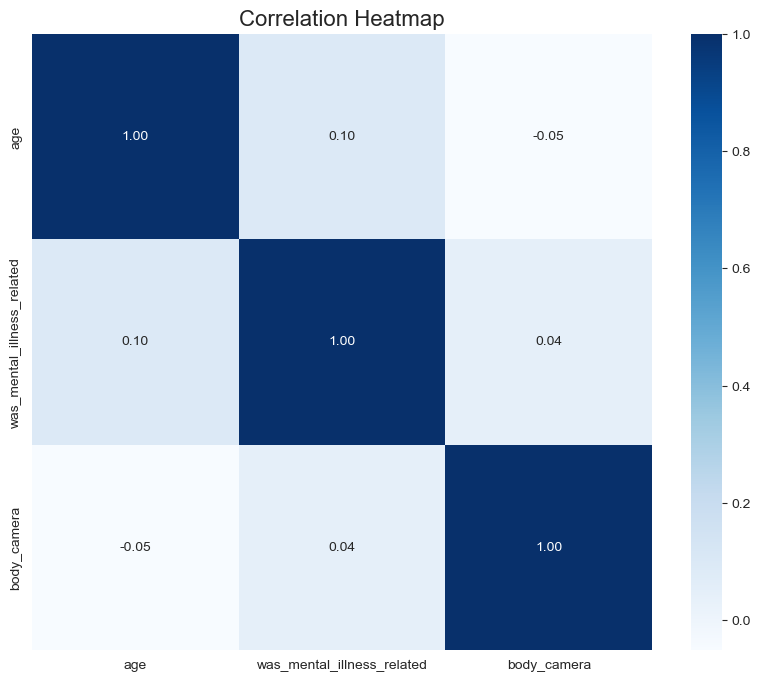

In [462]:
correl_df = merged_df[['age', 'was_mental_illness_related', 'body_camera']].dropna()

# correlation matrix for the filtered features (some integer features and bool types)
correlation_matrix = correl_df.corr()

# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap', fontsize = 16)
plt.show()

Overall correlation coefficients are very low for all 3 variables, implying that they not or very are weakly related to each other.

### Outliers

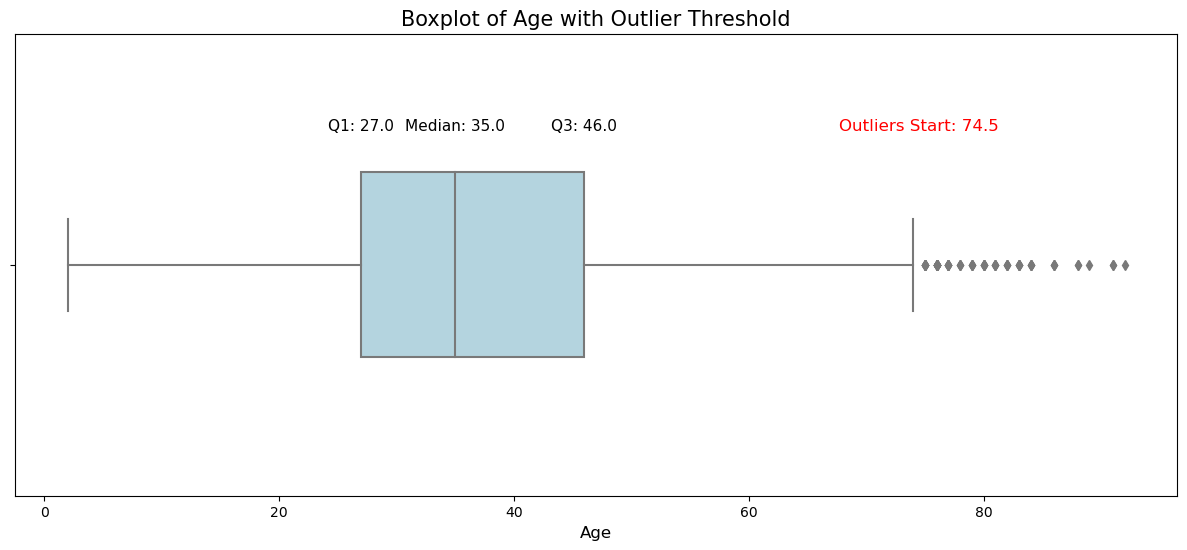

In [138]:
# quartiles for age
q1 = merged_df['age'].quantile(0.25)
q3 = merged_df['age'].quantile(0.75)
median = merged_df['age'].median()
upper_whisker = q3 + 1.5 * (q3 - q1)

# age boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x=merged_df['age'], color='lightblue', width=0.4)
plt.title('Boxplot of Age with Outlier Threshold', fontsize=15)
plt.xlabel('Age', fontsize=12)

# annotations
plt.text(q1, -0.3, f'Q1: {q1}', horizontalalignment='center', verticalalignment='center', fontsize=11, color='black')
plt.text(median, -0.3, f'Median: {median}', horizontalalignment='center', verticalalignment='center', fontsize=11, color='black')
plt.text(q3, -0.3, f'Q3: {q3}', horizontalalignment='center', verticalalignment='center', fontsize=11, color='black')
plt.text(upper_whisker, -0.3, f'Outliers Start: {upper_whisker}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
plt.show()

The age distribution for most of the data points falls below the age of 74.5 years, indicating that instances of police shootings involving individuals who are 74.5 years or older are very rare in this dataset.

If the data points are accurate the outliers might indicate exceptional cases. For example are older individuals involved in different types of incidents? 

In [390]:
# Identifing outliers 
outliers_df = merged_df[merged_df['age'] > 74.5]


# Count the types of incidents involving older individuals based on threat_type
threat_types_count = outliers_df['threat_type'].value_counts()

# Count the types of incidents involving older individuals based on armed_with
armed_with_count = outliers_df['armed_with'].value_counts()

# Count the types of incidents involving older individuals based on fleeing status
fleeing_count = outliers_df['flee_status'].value_counts()

# Count the types of incidents involving older individuals based on mental illness cases
illness_count = outliers_df['was_mental_illness_related'].value_counts()


# Print the counts
print("Incident counts for older individuals based on threat type:")
print(threat_types_count)
print("Incident counts for older individuals based on what they are armed with:")
print(armed_with_count)
print("Incident counts for older individuals based on what the fleeing status:")
print(fleeing_count)
print("Incident counts for older individuals based on mental illness cases:")
print(illness_count)

Incident counts for older individuals based on threat type:
point       27
shoot       21
threat      15
attack       2
move         1
accident     1
unknown      1
Name: threat_type, dtype: int64
Incident counts for older individuals based on what they are armed with:
gun        57
knife       6
unknown     3
replica     1
unarmed     1
Name: armed_with, dtype: int64
Incident counts for older individuals based on what the fleeing status:
not        53
unknown    12
car         2
foot        1
Name: flee_status, dtype: int64
Incident counts for older individuals based on mental illness cases:
False    44
True     24
Name: was_mental_illness_related, dtype: int64


Among older individuals involved in police killing incidents the most common threat types were pointing with 27 cases, shooting 21 cases and verbal threats with 15 cases. The vast majority (57 out of 68) of outlying older individuals were armed with guns. 
Most of the older individuals were not fleeing at the time of the incident, as indicated by 53 cases. Out of the 68 incidents involving older individuals 24 cases were related to mental illness

# Data exploration

## Time series analysis of fatal police shootings in US

In this part of the analysis I will look into cumulative monthly distribution of shootings by year. I will also check if there is particular time trend in shootings, age distributuon of victims of fatal shootings by police officer.
As well as gender, race, agency type, mental illness proportionality of those fatal shootings. We will explore agencies that caused most of the fatal shootings.

In [518]:
# number of shootings by year and month
monthly_data = merged_df.groupby(['year', 'month']).size().reset_index(name='count')

# storing counts 
cumulative_counts = []

for year in monthly_data['year'].unique():
    yearly_data = monthly_data[monthly_data['year'] == year].copy()
    yearly_data['cumulative_count'] = yearly_data['count'].cumsum()
    cumulative_counts.append(yearly_data)

cumulative_data = pd.concat(cumulative_counts)

# interactive plot to be able extract every and make comparisons
fig = px.line(cumulative_data, x='month', y='cumulative_count', color='year', 
              labels={'month': 'Month', 'cumulative_count': 'Cumulative Count'},
              title='Cumulative Monthly Distribution of Shootings by Year')
fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14
)

fig.show()

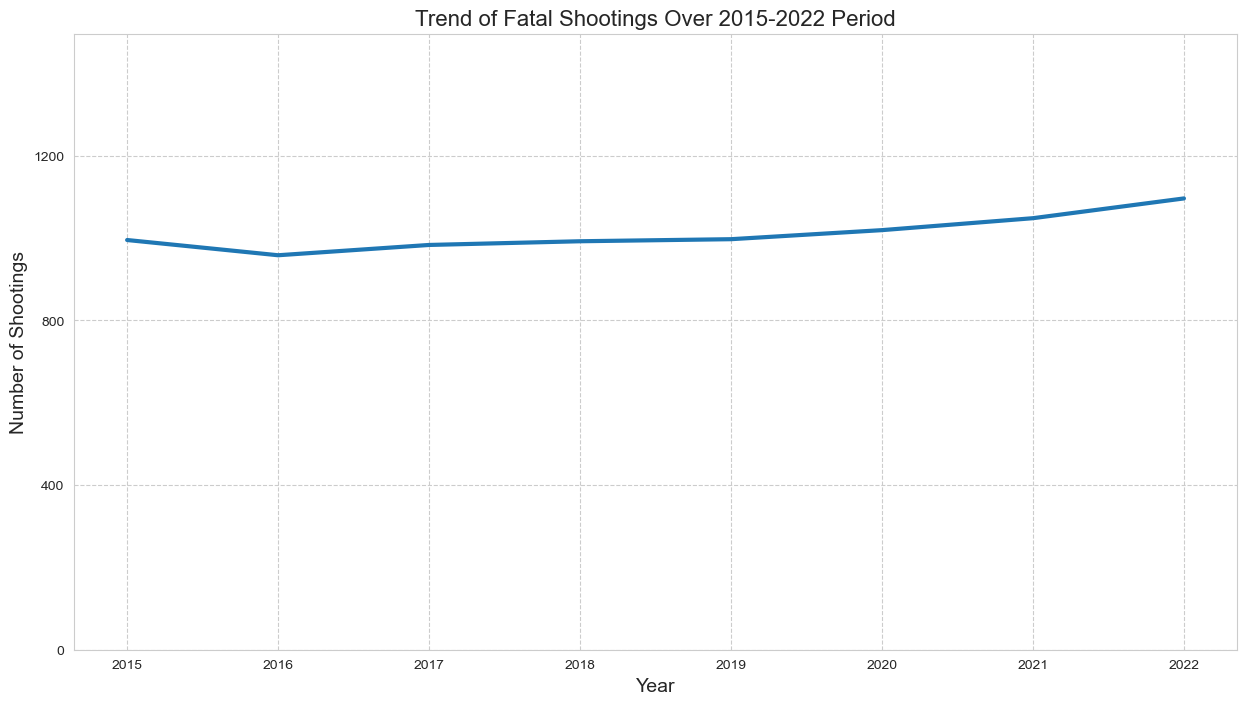

In [519]:
# removing 2023 year from the set for the yearly shootings plotting as it is not complete that year and might suggest 
# misleading results
year_filtered = merged_df[merged_df['year'] != 2023]

# shootings per year
shootings_per_periods = year_filtered.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(15, 8))
sns.lineplot(data=shootings_per_periods, x='year', y='count', lw = 3)
plt.ylim(0, max(shootings_per_periods['count']) + 400)
plt.yticks(range(0, max(shootings_per_periods['count']) + 400, 400))
plt.title('Trend of Fatal Shootings Over 2015-2022 Period', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Shootings', fontsize=14)
plt.grid(True, linestyle='--')
plt.show()

In [520]:
 # table of total fatal police oficers shootings over the years and percentage from the last year
shootings_per_periods['percentage_change'] = shootings_per_periods['count'].pct_change() * 100  
shootings_per_periods

,year,count,percentage_change
0,2015,995,NaN
1,2016,958,-3.718593
2,2017,983,2.609603
3,2018,992,0.915565
4,2019,997,0.504032
5,2020,1019,2.206620
6,2021,1048,2.845927
7,2022,1096,4.580153


From the accumulated data of fatal shootings over the months from January 2015 to July 2023, as well as the trend line plot and the table of shootings per period, I see a increasing trajectory in the number of fatal police shootings. Alarmingly, 2022 saw the highest year-over-year increase, with a 4.58% increase compared to 2021. This is conserning because there have been unique periods like the COVID-19 pandemic, which, intuitively, one might expect to have led to less police and society activities .

It's worth mentioning that while the percentage change fluctuates, it has not decreased into the negative since 2016, suggesting that the general trend, despite small changes, is upward. 

Future analyses should focus on dissecting the circumstances surrounding these fatal shooting events. This could include looking at geographical distribution, the context in which these shootings occur, the demographics of the victims.

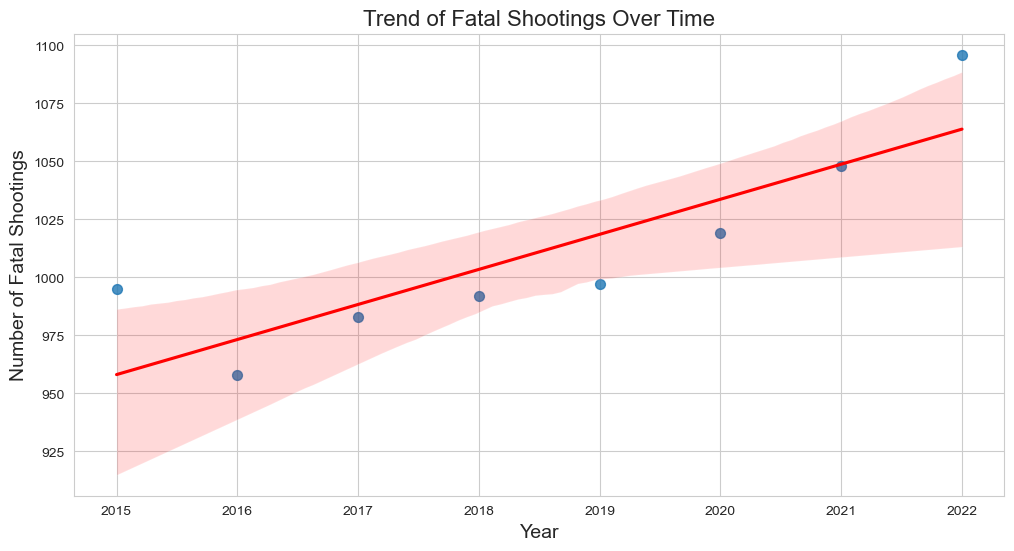

In [521]:
# plotting the year shootings with regression line
plt.figure(figsize=(12, 6))
sns.regplot(data=shootings_per_periods, x='year', y='count', scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Trend of Fatal Shootings Over Time', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Fatal Shootings', fontsize = 14)
plt.show()

In [522]:
# setting independent and dependance variables
X = shootings_per_periods[['year']]
y = shootings_per_periods['count']

X = sm.add_constant(X) # adding intercept (this creates an additional column of 1  and allows to find the slope

# egression model
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     16.63
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00651
Time:                        14:47:56   Log-Likelihood:                -35.634
No. Observations:                   8   AIC:                             75.27
Df Residuals:                       6   BIC:                             75.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.951e+04   7483.080     -3.943      0.008   -4.78e+04   -1.12e+04
year          15.1190      3.707      4.078      0.007       6.048      24.190
==============================================================================
Omnibus:                        2.262   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                1.315
Skew:                           0.902   Prob(JB):                        0.518
Kurtosis:                       2.168   Cond. No.                     1.78e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

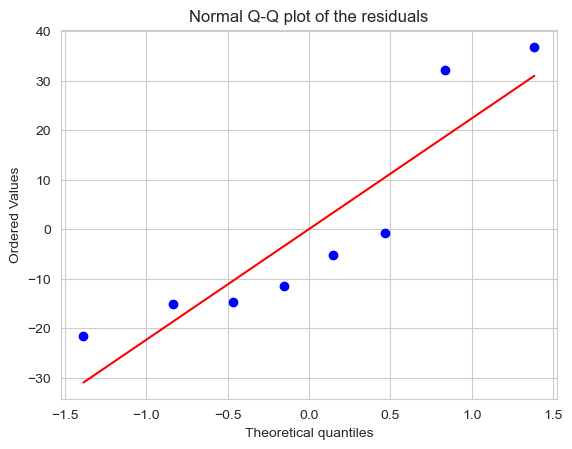

In [523]:
# Q-Q plot for normality check. 
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q plot of the residuals')
plt.show()

Q-Q plot might be showing some skewness to the left. Therefor model might be not the most reliable, however model has only 1 independent variable. R-squared as well as p-value for the overall significance of the regression is small p-value (< 0.05). This indicaties that the model can be treated as statistically significan.

The increasing trend in fatal shootings, together with a relatively high level of confidence and the linear regression model predictions of fatal police shootings is alarming. The model tells us that the number of fatal shootings has been increasing about 15 incidents each year from 2015 to 2022, and we can expect to have ~1079 fatal shootings in 2023. The model is relatively reliable but not perfect, it captures about 73.5% of the overall police shootings variation.

Future analyses will focus on dissecting the circumstances surrounding these fatal shooting events. This could include looking at factors such as geographical distribution, the context in which these shootings occur, the demographics of the victims.

## Fatal shootings seasonality 

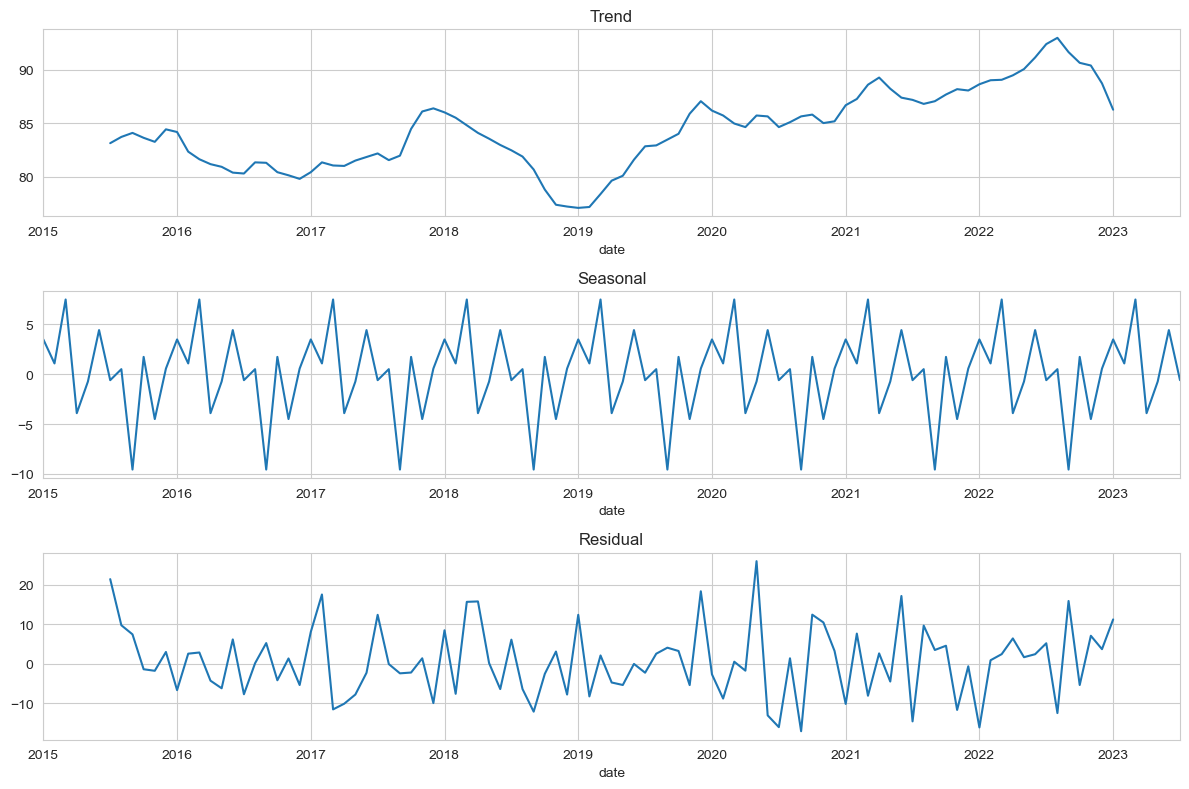

In [530]:
monthly_data = df.resample('M', on='date').size().reset_index(name='count') # Summing shooting by the month
monthly_data.set_index('date', inplace=True) # Setting date to be the index for seasonal analysis

# Seasonal decomposition
decomposition = seasonal_decompose(monthly_data['count'], model='Additive') # selected additive model

# Plotting trend, seasonality and residuals
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
decomposition.trend.plot(ax=ax1, title='Trend')
decomposition.seasonal.plot(ax=ax2, title='Seasonal')
decomposition.resid.plot(ax=ax3, title='Residual')
plt.tight_layout()
plt.show()

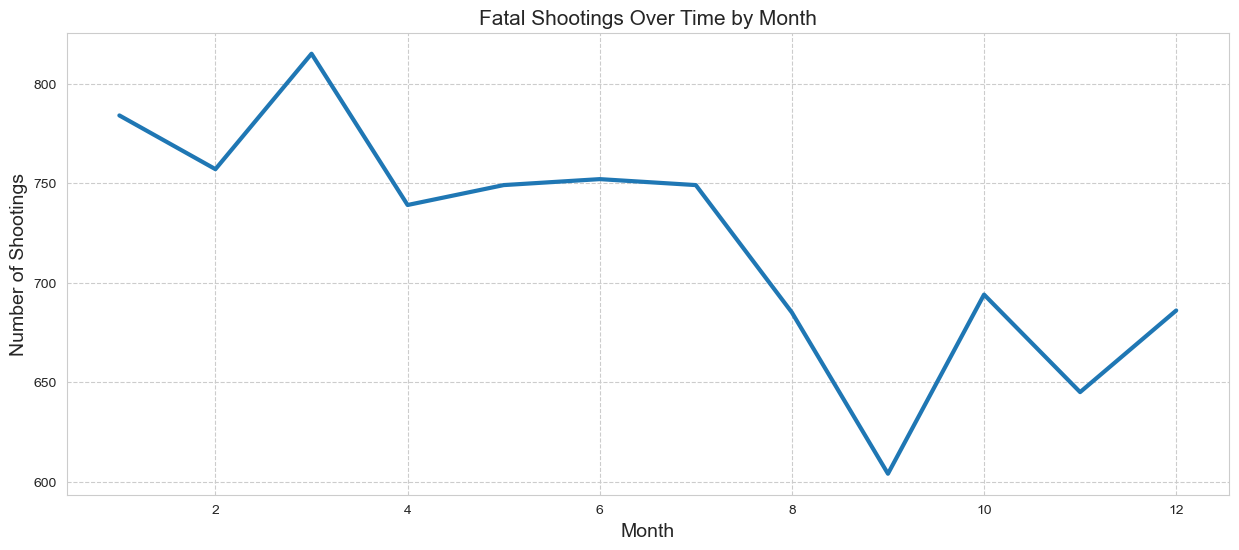

In [532]:
# Grouping by month
shootings_per_month = merged_df.groupby('month').size().reset_index(name='count')

# Create the line plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=shootings_per_month, x='month', y='count', lw=3)
plt.title('Fatal Shootings Over Time by Month', fontsize=15)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Shootings', fontsize=14)
plt.grid(True, linestyle='--')
plt.show()

From both the seasonally decomposed data and the monthly shooting counts, we can clearly identify cyclical patterns occurring over the months. Fatal police shootings tend to decrease during the spring and summer periods and increase starting from the autumn season until almost the end of winter.

# Fatal police shootings distribution among different groups

## What is the distribution of fatal shootings based on age?

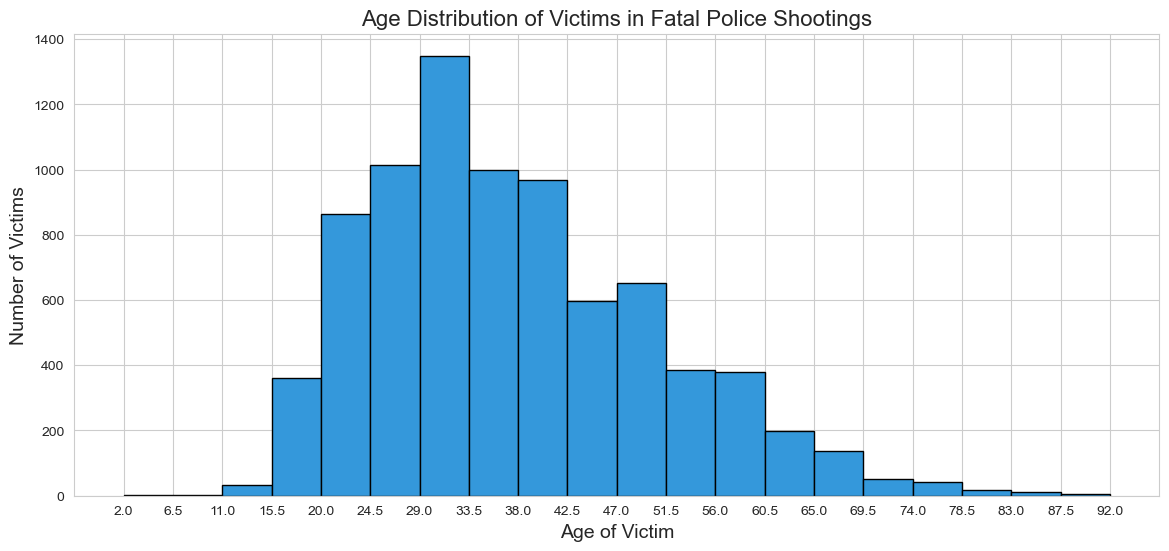

In [533]:
# Histogram of ages
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))
num_bins = 20 # number of bins 
counts, bin_edges, patches = plt.hist(merged_df['age'], bins=num_bins, color='#3498db', edgecolor='black')

plt.xticks(bin_edges) # seting xticks to bin edges
plt.xlabel('Age of Victim', fontsize=14)
plt.ylabel('Number of Victims', fontsize=14)
plt.title('Age Distribution of Victims in Fatal Police Shootings', fontsize=16)
plt.show()

The distribution is slightly right skewed, this suggests that there are more instances of older individuals being shot compared to very young ones, but the majority still falls within the 20 to 40 young age range. 

## What is the distribution of fatal shootings based on gender?

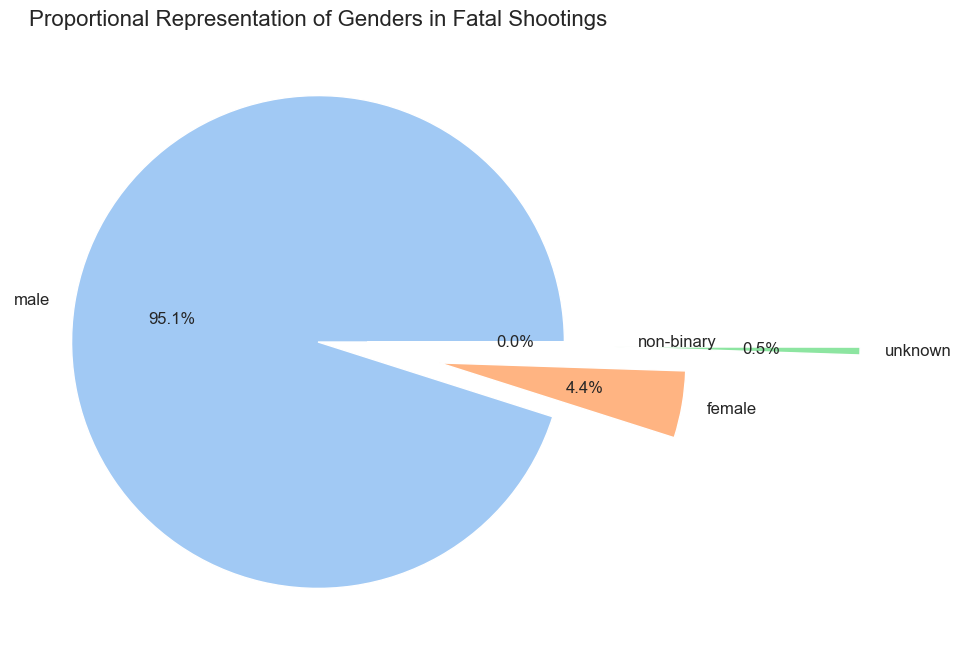

In [534]:
# gender group count data
gender_counts = merged_df['gender'].value_counts()

# explode list for smaller proportion gender values
explode_values = [1.2 if gender == 'unknown' else 0.5 if gender == 'female' else 0.2 if gender == 'non-binary' else 0 for gender in gender_counts.index]

# gender distribution pie chart
plt.figure(figsize=(12, 8))
palette = sns.color_palette("pastel", n_colors=len(gender_counts))
gender_counts.plot(kind='pie', colors=palette, autopct='%1.1f%%', explode=explode_values, textprops={'fontsize': 12})
plt.title('Proportional Representation of Genders in Fatal Shootings', fontsize = 16)  
plt.ylabel('')
plt.show()

Overwhelming majority of the fatal police shootings victims in the data are males, accounting for 95.1% in all cases. While females make up only 4.4% of the victims. This significant gender difference raises questions about the circumstances and factors that lead to these fatal shootings. 

## What is the distribution of fatal shootings based on race?

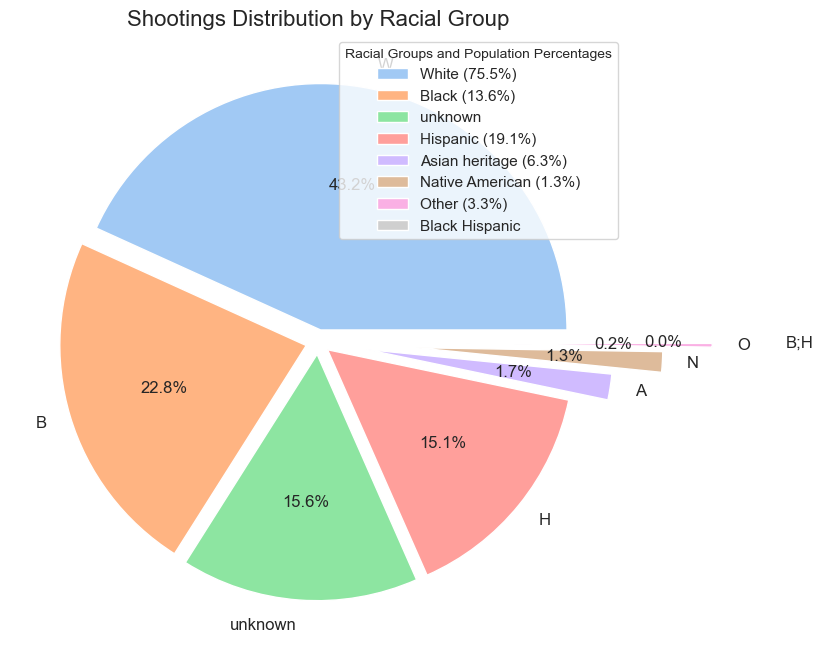

In [535]:
# race value counts
race_counts = merged_df['race'].value_counts()

# explode list for smaller proportion race values to be clearly visible on the pie chart
explode_values = [
    0.2 if race == 'A' else 
    0.4 if race == 'N' else 
    0.6 if race == 'O' else 
    0.8 if race == 'B;H' else 
    0.05 
    for race in race_counts.index
]

# setting colours to pastel
palette = sns.color_palette("pastel", n_colors=len(race_counts))

# race groups and their descriptions for the legend
race_labels = {
    'W': 'White (75.5%)',
    'B': 'Black (13.6%)',
    'A': 'Asian heritage (6.3%)',
    'N': 'Native American (1.3%)',
    'H': 'Hispanic (19.1%)',
    'O': 'Other (3.3%)',
    'B;H': 'Black Hispanic',
    'unknown': 'unknown'
}

plt.figure(figsize=(16, 8))
plt.pie(race_counts, labels=race_counts.index, colors=palette, autopct='%1.1f%%', textprops={'fontsize': 12}, explode=explode_values)
plt.title('Shootings Distribution by Racial Group', fontsize=16)
plt.legend([race_labels.get(x, x) for x in race_counts.index], loc='best', fontsize=11, title='Racial Groups and Population Percentages')
plt.show()

The pie chart illustrating the racial distribution of fatal police shootings reveals some disparities when compared to the overall demographic composition of the United States according to the 2022 Census data. While whites make up 75.5% of the general population, they account for 43.2% of the fatal shooting victims. Black individuals make 13.6% of US population but account for a much higher 22.8% of fatal police shootings cases.

Hispanics make 19.1% of the US population and 15.1% of the shooting victims, which is relatively closer to their representation in the general population of US. Individuals of asian heritage and native americans are closely mirroring their actual population percentages of 6.3% and 1.3%.

Note:With the introduction of version 2 of the fatal shootings database, the Washington Post has began tracking multiple races. Prior to 2021, only one race was assigned to the victims.

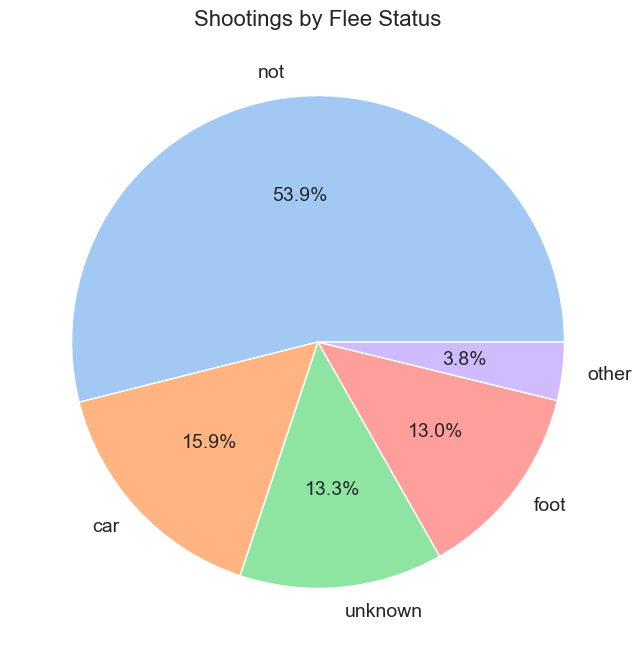

In [536]:
# percentages of flee statuses
flee_counts = merged_df['flee_status'].value_counts()

palette = sns.color_palette("pastel", n_colors=len(flee_counts))
plt.figure(figsize=(16, 8))
plt.pie(flee_counts, labels=flee_counts.index, colors=palette, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.title('Shootings by Flee Status', fontsize=16)
plt.show()

Distribution of fleeing status in fatal police shootings shows various scenarios. Majority 53.9% were not even fleeing at the time of the incident. This highlights that over half of the fatal shootings occur without the individual attempting to escape. On the other hand fleeing by car accounts for 15.9% of the cases and fleeing on foot represents 13% and together suggest that about 29% of the individuals were trying to evade the police.

It is also important to note that 13.3% of cases, the fleeing status is not known. This missing information could potentially have an impact the interpretation blow already big proportions of some statuses.

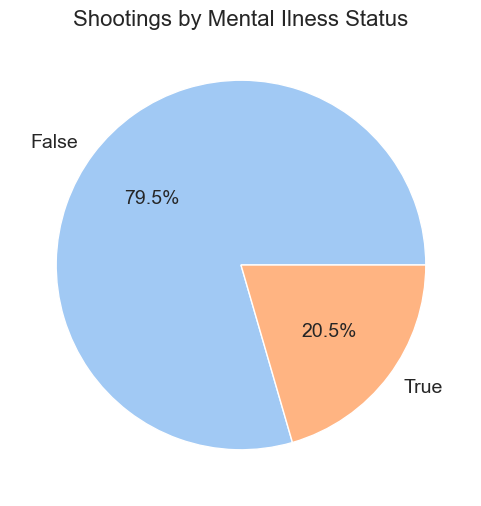

In [539]:
# mental illness case counts
mental_illness_counts = merged_df['was_mental_illness_related'].value_counts()

palette = sns.color_palette("pastel", n_colors=len(mental_illness_counts))
plt.figure(figsize=(14, 6))
plt.pie(mental_illness_counts, labels=mental_illness_counts.index, colors=palette, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.title('Shootings by Mental Ilness Status', fontsize=16)
plt.show()

The pie chart of shootings by mental ilness status reveals that mental illness is a notable factor in proportion of fatal police shootings and accounts for 20.5% of all the cases. However the majority of incidents - 79.5% did not involve individuals with mental illness.

The fact that >20% of the cases involve mental illness raises an important question about how police officers behaves with individuals who have mental problems.

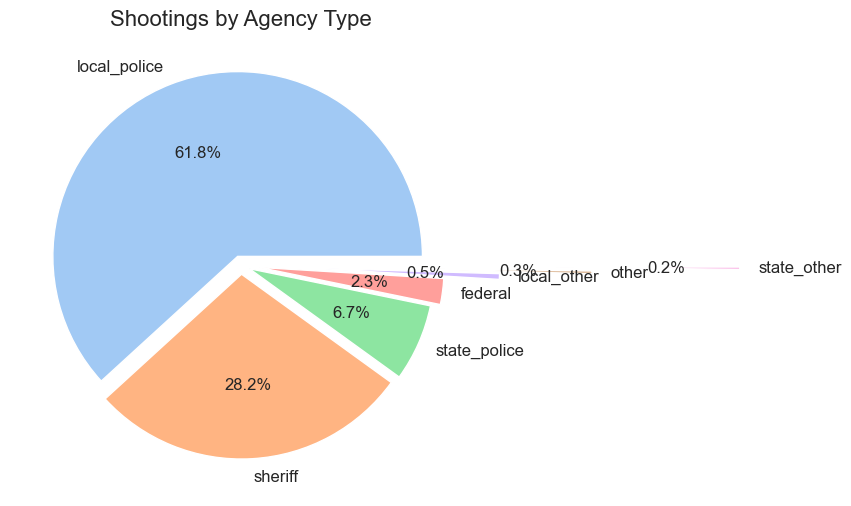

In [540]:
# percentage of agency types
types_counts = merged_df['type'].value_counts()

# explode list for smaller proportion agency types values to be clearly visible on the pie chart
explode_values = [
    0.1 if type == 'federal' else 
    0.4 if type == 'local_other' else 
    1.7 if type == 'state_other' else 
    0.9 if type == 'other' else
    0.05 
    for type in types_counts.index
]

palette = sns.color_palette("pastel", n_colors=len(types_counts))
plt.figure(figsize=(14, 6))
plt.pie(types_counts, labels=types_counts.index, colors=palette, autopct='%1.1f%%',textprops={'fontsize': 12},  explode=explode_values)
plt.title('Shootings by Agency Type', fontsize=16)
plt.show()

This pie chart shows the distribution of agency types involved in fatal police shootings. Local police agencies account for the majority with 61.8% of the all cases followed by sheriffs which make 28.2% of all the fatal incidents. State police are involved in a smaller proportion of shootings contributing to 6.7%. Federal agencies are even less common accounting for just 2.3% of the cases. The remaining of the incidents are attributed to various other types of local and state agencies.

This distribution suggests that most fatal police shootings occur on the local level, with some intuition that one of the possible factors could be higher level of public activity. However this not a fact and should explored with additional data.

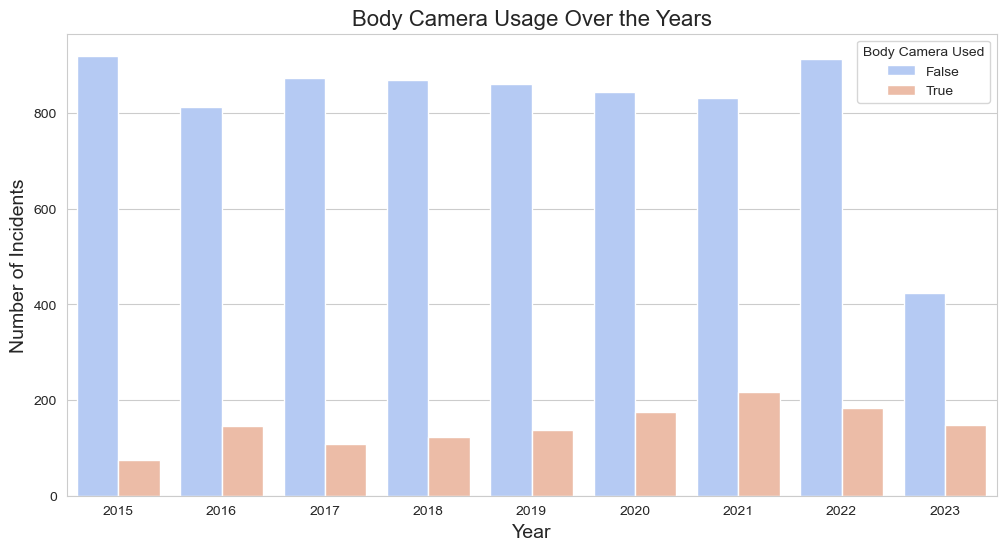

In [541]:
# grouped by the year and body camera counted occurances
yearly_camera_usage = merged_df.groupby(['year', 'body_camera']).size().reset_index(name='count')

# yearly bar chart of camera usage and non usage cases
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_camera_usage, x='year', y='count', hue='body_camera', palette='coolwarm')
plt.title('Body Camera Usage Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.legend(title='Body Camera Used')
plt.show()

The bar chart of body camera usage over the ears provides insights into the frequency of shootings incidents where body cameras were used versus not used across all available years 2015 - 2023. Noticeable difference in the frequency of incidents where body cameras are used versus those where they aren't. From 2017 to 2021 gap between camera used and not used cases seem to have descreasing, however in 2022 cases were body camera was not used increased and cases were it used decreased. Even though 2023 data is not complete it looks promising in decreasing the gap as case where cameras are used almost reached 2022 number of shootings incidence and not used haven't reached half of 2022 cases.

### Distribution of fatal police shootings by race across agency types

In [542]:
#  removing row where race is 'B;H' as it has only 1 value and could have an effect to significance testing
filtered_BH = merged_df[merged_df['race'] != 'B;H']

# creating contingecy table
type_race_contingency_table = pd.crosstab(filtered_BH['type'], filtered_BH['race'])

# Chi-Square test
chi2, p_value, _, _ = chi2_contingency(type_race_contingency_table)

if p_value < 0.05:
    print(f"The distribution of fatal shootings by race differs significantly across agency types. P-value: {p_value}")
else:
    print(f"The distribution of fatal shootings by race does NOT differ significantly across agency types. P-value: {p_value}")

The distribution of fatal shootings by race differs significantly across agency types. P-value: 2.613613951145816e-115


Chi-Square test is a statistical method used to assess the relationship between two categorical variables. In this exercise I wanted to explore whether there's a relationship between the race of individuals who are fatally shot by the police and the type of agency involved in the shooting.

Hypotheses:
H0: There is no relationship between the type of agency and the race of individuals they fatally shot. 

H1: There is a relationship between the type of agency and the race of individuals they fatally shoot. This would imply that different types of agencies may be more likely to fatally shoot individuals of specific race.

Chi-square test found a highly significant result. The p-value was extremely close to zero and far below the commonly used significance level of 0.05.It is possible to confidently reject the H0. This means that there is indeed a statistically significant relationship between the type of agency and the race of the individuals they fatally shoot.

<Figure size 1200x600 with 0 Axes>

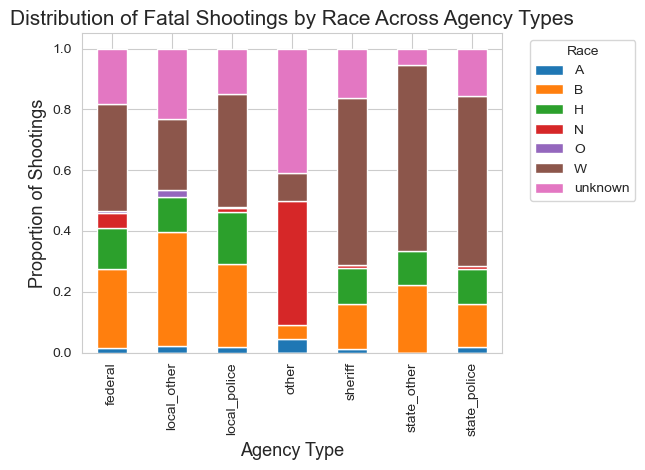

In [543]:
# Normalizing so each row would sum up to 1, to get the proportion of each race within each agency type
contingency_table_normalized = type_race_contingency_table.div(type_race_contingency_table.sum(axis=1), axis=0)

# Plotting
plt.figure(figsize=(12, 6))
contingency_table_normalized.plot(kind='bar', stacked=True)
plt.title('Distribution of Fatal Shootings by Race Across Agency Types', fontsize = 15)
plt.xlabel('Agency Type', fontsize = 13)
plt.ylabel('Proportion of Shootings', fontsize = 13)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

I then plotted a stacked bar chart to represent these proportions. The x-axis represents different types of agencies, and the y-axis represents the proportion of fatal shootings divided by race. I would like to highlight few difference: local other agency has higher proportion of black individual shot than white, this is alarming because according according to the US 2022 Census data black ethnicity individual make 13.6% of the US population while white 75.5%. It is not only local other that reveal alarmining differences, federal and local police agencies have similiar proportions of fatal shootings of white and black race individual even though general population of these ethnicities in the US are more than 5 times different (White - 75.5%), Black - 13.6%)
Other type agency also show an alarming trend with regard to fatal shootings involving Native American individuals. Given that we don't know what other agency type is there could be some additional insight explaining partially these results as well as the fact that other type agency make 0.3% of all fatal shootings analysed here. Without detailed analyses it is better not draw disturbing conclusions in this case. 

### Distribution of fatal police shootings by age across different racial groups

In [544]:
# dropping missing age values for further exploration of age variation within groups
age_cleaned_df = filtered_BH.dropna(subset=['age'])

# Removing outliers
z_scores = np.abs(stats.zscore(age_cleaned_df['age'])) # z-score for outlier identification
outliers = (z_scores > 3)
age_data_no_outliers = age_cleaned_df[~outliers]

In [545]:
# grouping by race factor
race_groups = age_data_no_outliers.groupby('race')['age'].apply(list).to_dict()

# ANOVA (Analysis of variance)
f_value, p_value = f_oneway(*race_groups.values())

# statistical significance results
if p_value < 0.05:
    print(f"The average age is significantly different among the different racial groups (p-value = {p_value})")
else:
    print(f"The average age is not significantly different among the different racial groups (p-value = {p_value})")

The average age is significantly different among the different racial groups (p-value = 4.795778536597116e-119)


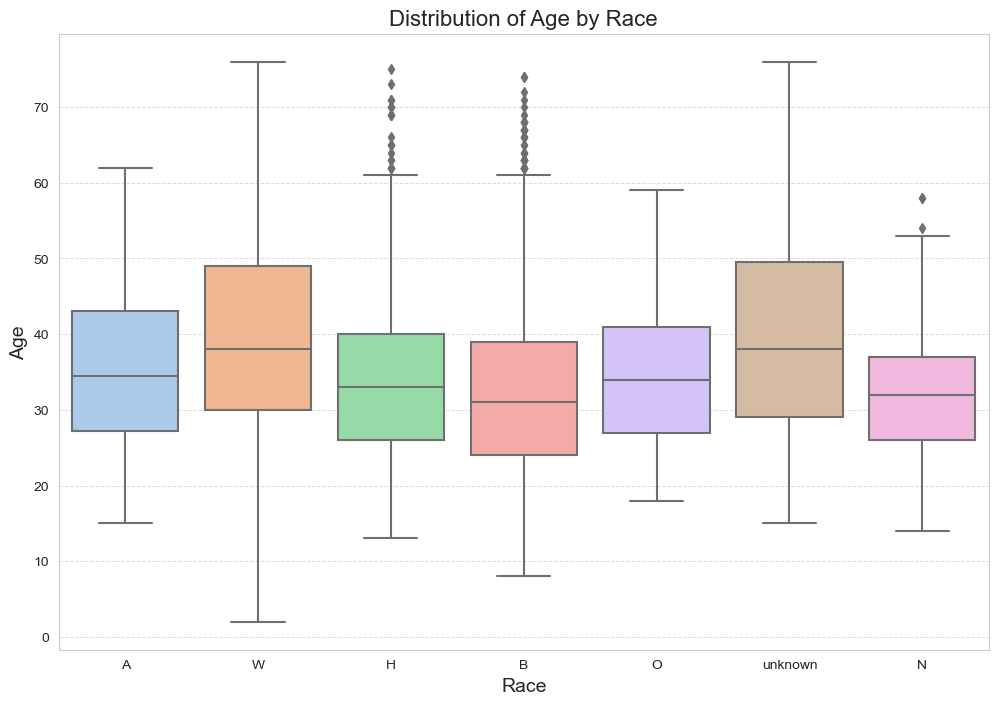

In [546]:
plt.figure(figsize=(12, 8))  
sns.boxplot(x='race', y='age', data=age_data_no_outliers, palette='pastel')  

plt.title('Distribution of Age by Race', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

ANOVA (Analysis of Variance) test was performed to examine if there are statistically significant differences in the ages among various racial groups involved in the police shooting incidents. The results reveal that there is a significant difference in age distribution among the different racial groups, with a near-zero p-value.

The box plot visually supports these findings, notably highlighting variations and outliers in age among the Black, Hispanic, and Native American groups. These outliers are particularly interesting because these racial groups have been identified in previous analyses as being disproportionately affected by incidents.

### Distribution of fatal police shootings by age across agency types

In [547]:
# Prepare the data
type_groups = age_data_no_outliers.groupby('type')['age'].apply(list).to_dict()

# Perform one-way ANOVA
f_value, p_value = f_oneway(*type_groups.values())

# Check for statistical significance
if p_value < 0.05:
    print(f"The average age is significantly different among the different agency type groups (p-value = {p_value})")
else:
    print(f"The average age is not significantly different among the different agency type groups (p-value = {p_value})")

The average age is significantly different among the different agency type groups (p-value = 2.1737618327833384e-24)


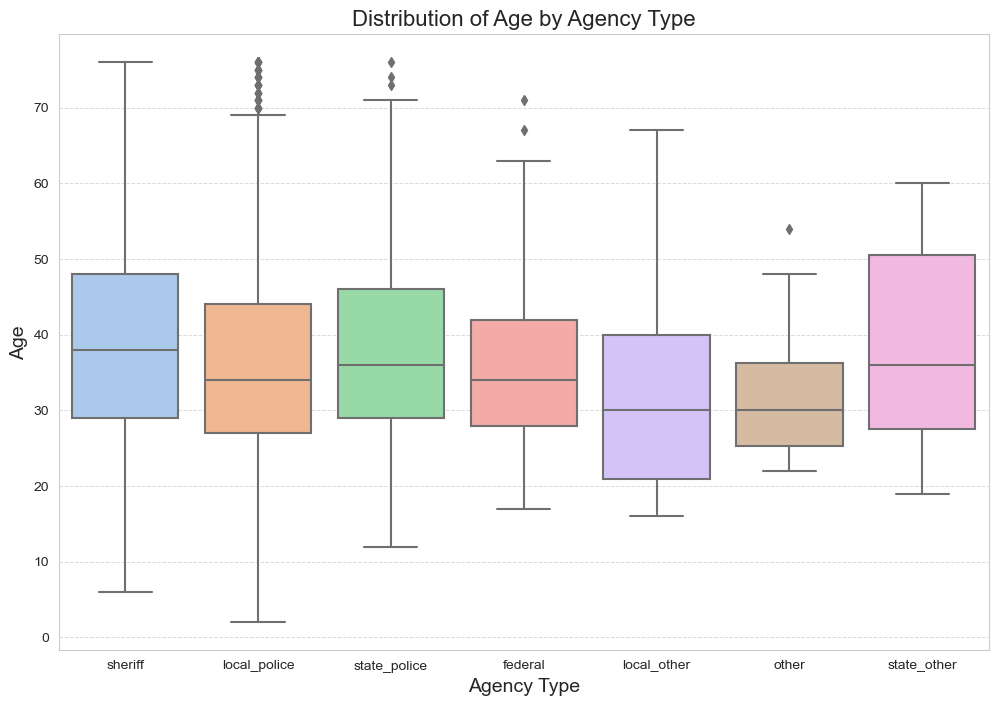

In [548]:
plt.figure(figsize=(12, 8))  
sns.boxplot(x='type', y='age', data=age_data_no_outliers, palette='pastel')  

plt.title('Distribution of Age by Agency Type', fontsize=16)
plt.xlabel('Agency Type', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

The p-value from the ANOVA test is extremely low, which means it is possible to state that there is a statistically significant difference in the mean ages of the various racial groups included in the study.

The boxplot reveals notable variations in the age distribution across different types of police agencies. Local Other and Sheriff show a larger age range, suggesting more variability in the ages of individuals involved in fatal incidents. But most notable results are from Local Police and Sherriff agency groups they stand out with the broadest age range starting from less than 10 years young victims.

## How many shootings were recorded in each state? 

In [549]:
state_counts = merged_df['state'].value_counts()
state_counts_df = state_counts.reset_index()
state_counts_df.columns = ['state', 'count']

fig = px.choropleth(
    state_counts_df, 
    locations='state', 
    locationmode="USA-states", 
    color='count', 
    hover_name='state', 
    title='Fatal Shootings by State',
    labels={'count': 'Number of Shootings'},
    scope="usa",
    color_continuous_scale=px.colors.sequential.Redor
)

fig.show()

In [550]:
top_5 = 5
# US states with the highest numbers of fatal shootings
top_states = state_counts.sort_values(ascending=False).head(top_5)

# states with the lowest numbers of fatal shootings
bottom_states = state_counts.sort_values().head(top_5)

print("Top 5 states with most fatal shootings:".format(top_5))
print(top_states)
print("\nTop 5 states with least fatal shootings:".format(top_5))
print(bottom_states)

Top 5 states with most fatal shootings:
CA    1222
TX     798
FL     554
AZ     395
GA     329
Name: state, dtype: int64

Top 5 states with least fatal shootings:
RI     7
VT    14
ND    19
DE    19
CT    23
Name: state, dtype: int64


Both shootings map and top 5 list of most and least fatal shootings show that California, Texas, and Florida lead in the number of fatal shootings, which also possibly aligns with their larger populations but could also point to other contributing factors like guns laws or general social issues.States like Rhode Island, Vermont, North Dakota, Delaware, and Connecticut have the least number of fatal shootings, which again might suggest that size and general population could be a contributing factors.

In [551]:
# grouping by state
state_groups = age_data_no_outliers.groupby('state')['age'].apply(list).to_dict()

#  ANOVA
f_value, p_value = f_oneway(*state_groups.values())

# statistical significance checking using p-value
if p_value < 0.05:
    print(f"The average age is significantly different among the states (p-value = {p_value})")
else:
    print(f"The average age is not significantly different among the states (p-value = {p_value})")

The average age is significantly different among the states (p-value = 3.1961584875552143e-09)


The ANOVA test indicates that the average age of individuals involved in fatal shootings varies significantly among the different states with a highly significant p-value of 3.1961584875552143e-09. This suggests that the issue of fatal shootings and the demographics it affects is not even across the US states. However geeral population factors should be added into future exploration of these findings to be certain of the points being made.

In CA, the average age is significantly different among the different racial groups (p-value = 3.025300962004353e-10)


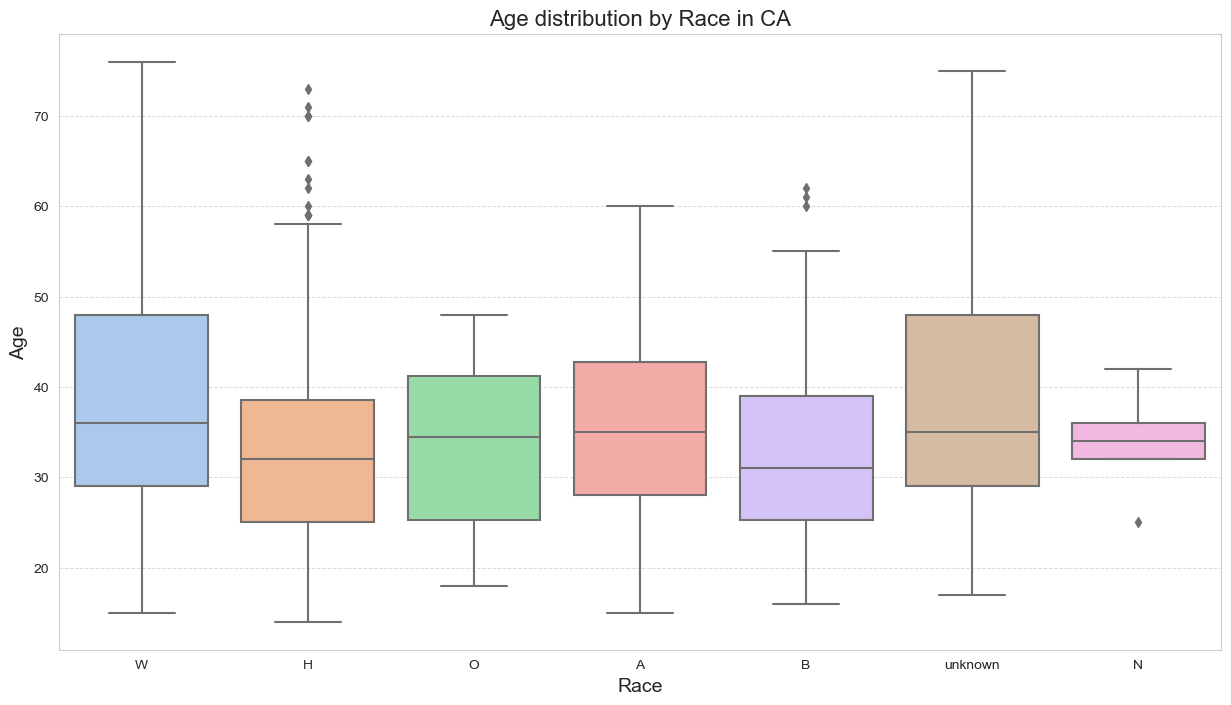

In TX, the average age is significantly different among the different racial groups (p-value = 2.508641915805924e-09)


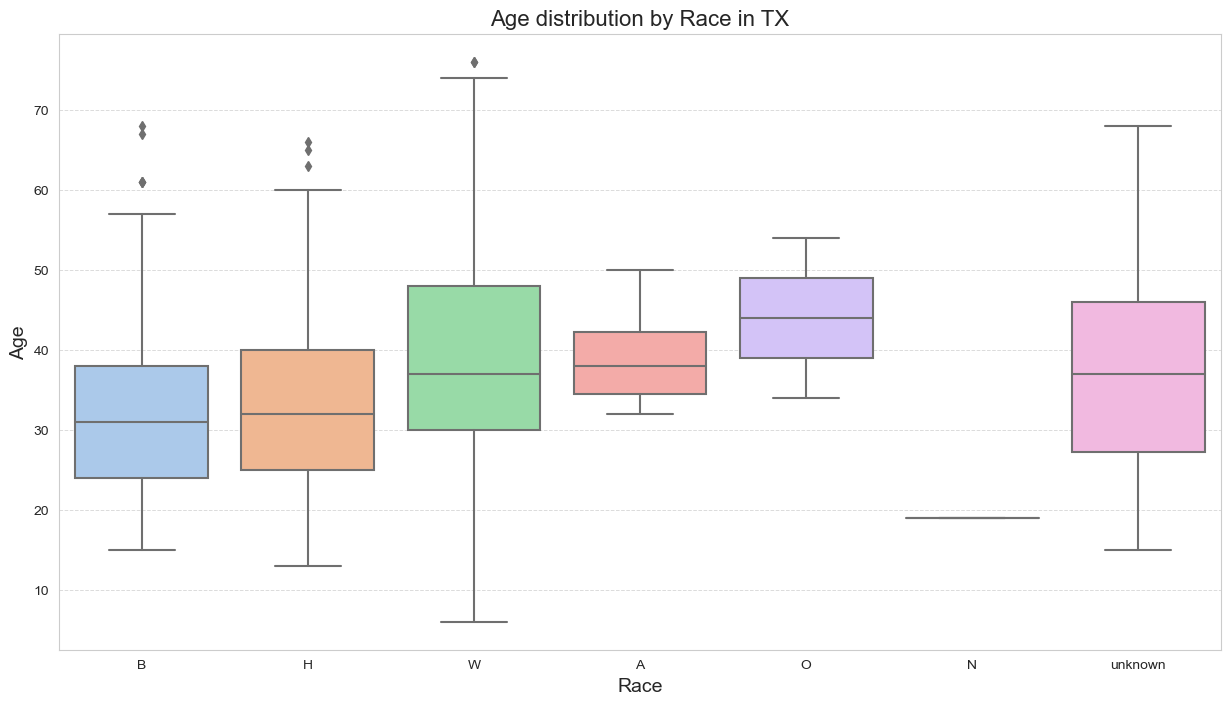

In FL, the average age is significantly different among the different racial groups (p-value = 2.3442054158750037e-09)


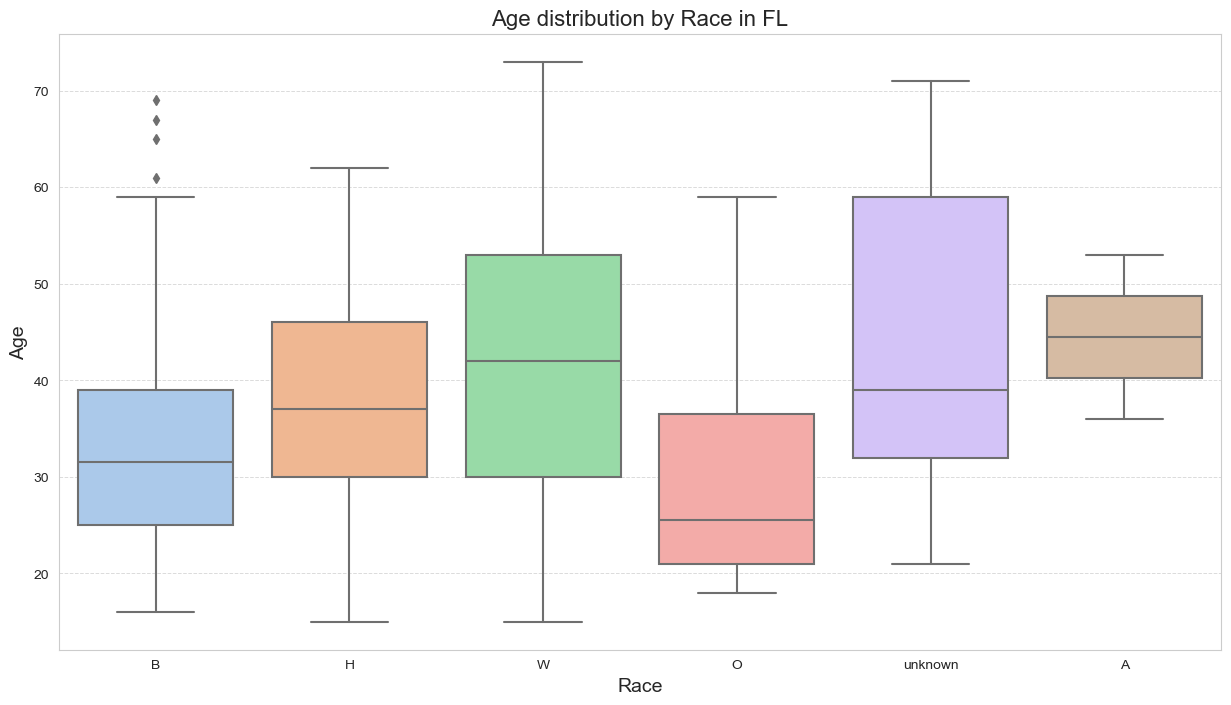

In [552]:
# filltering most shooting having states CA, TX, and FL
filtered_state_df = age_data_no_outliers[age_data_no_outliers['state'].isin(['CA', 'TX', 'FL'])]

for state in ['CA', 'TX', 'FL']:
    state_data = filtered_state_df[filtered_state_df['state'] == state]
    race_groups = state_data.groupby('race')['age'].apply(list).to_dict()
    
    f_value, p_value = f_oneway(*race_groups.values())
    
    if p_value < 0.05:
        print(f"In {state}, the average age is significantly different among the different racial groups (p-value = {p_value})")
    else:
        print(f"In {state}, the average age is not significantly different among the different racial groups (p-value = {p_value})")
        
    plt.figure(figsize=(15, 8))  
    sns.boxplot(x='race', y='age', data=state_data, palette='pastel')  

    plt.title(f'Age distribution by Race in {state}', fontsize=16)
    plt.xlabel('Race', fontsize=14)
    plt.ylabel('Age', fontsize=14)
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.show()

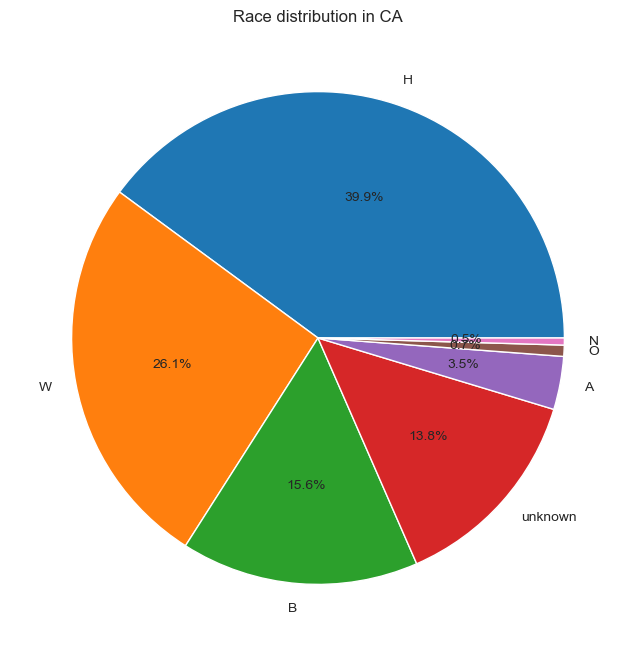

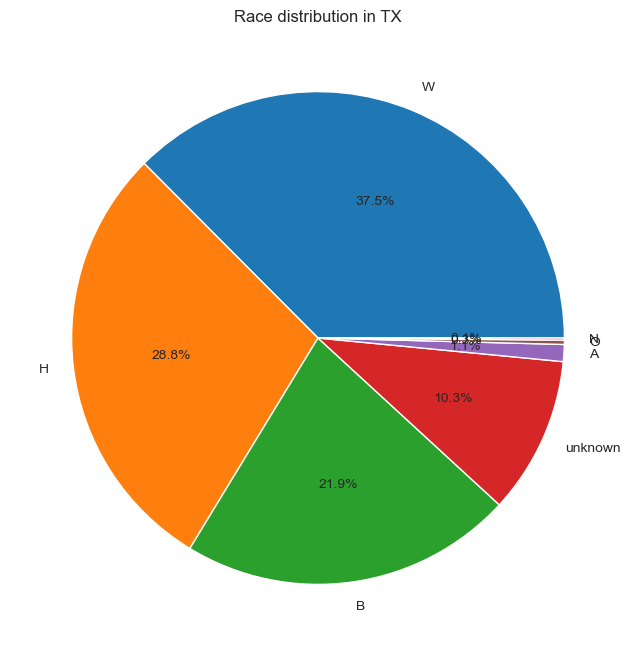

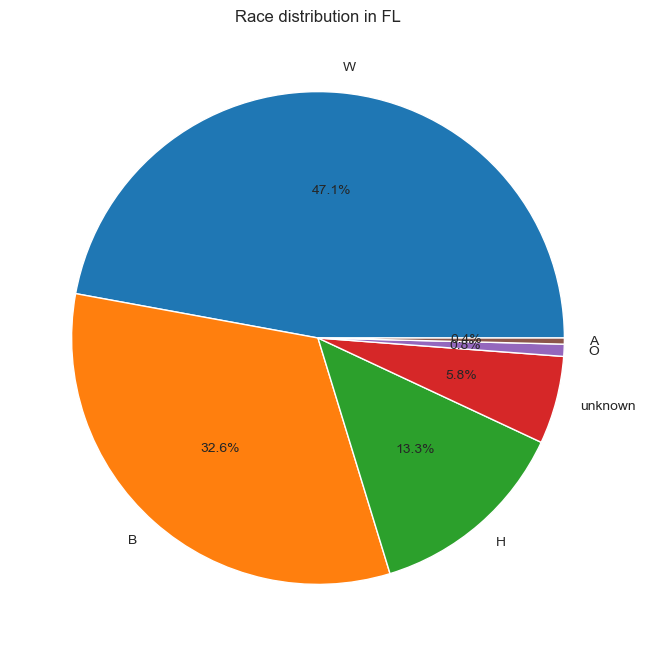

In [553]:
# Pie chart of race groups proportions for California, Texas and Florida states
for state in ['CA', 'TX', 'FL']:
    state_data = filtered_state_df[filtered_state_df['state'] == state]
    race_counts = state_data['race'].value_counts()
    colors = plt.cm.Paired(range(len(race_counts)))
    
    plt.figure(figsize=(8, 8))
    plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%')
    plt.title(f'Race distribution in {state}')
    plt.show()

In California our analysis reveals statistically significant variations in the average age of fatal police shooting victims among different racial groups (p-value = 3.025300962004353e-10). The age distribution ranges widely from individuals younger than 20 years old to those older than 70 years, particularly in the white and 'unknown' racial categories. Hispanic racial group, on the other hand, stands out for having victims as young as 10 years old and a significant number of outliers starting slightly below 60 years old. Our data suggests that hispanic individuals in California are more likely to be victims of fatal police shootings at younger ages below 60 years old. This is notable as hispanics make up the largest proportion of such incidents in the state(39.9%), with almost half of them being younger than 30 years old.

In Texas a statistically significant difference exists in the mean age among various racial groups involved in fatal police shootings as indicates p-value of 2.508641915805924e-09. TWhite racial group is particularly interesting, accounting for 37.5% of all such incidents in the Texas state. Moreover, the age range within this racial category is highly diverse, spanning from victims younger than 10 years old to those over 70 years old. Notably, about a quarter of the white victims fall within the older age range, from nearly 50 years old to above 70. 

In Florida there is a statistically significant difference in the average age of victims among different racial groups involved in fatal police shootings, as supported by a p-value of 2.3442054158750037e-09. The white racial group accounts for 47.1% of all such incidents, closely followed by the black racial group, which makes 32.6% of the shootings. Age distribution within these major racial groups exhibits distinct variations. For the white racial group, the age range of victims is broad, stretching from younger than 10 years old to those over 70. Moreover the median age within this group is on the higher side, indicating that half of the individuals fatally shot by police are of an older age. In an opposite way, black racial group also shows a considerable range in age, with incidents occurring among individuals as young as 20 years old to those as old as 70. However, the median age is just above 30 years, suggesting that half of the victims belonging to this ethnic group are younger than 30 years old. This highlights the different age dynamics associated with police shootings among these two major racial groups in Florida.

# Conclusions

    The analysis of the dataset of fatal police shootings from January 2015 to July 2023 presents some interesting insights about police killings in US. With 8659 records from 51 states, the data offers a look into the frequency and demographics of such incidents. Most notably, the data points towards an increasing trend in fatal police shootings, with 2022 marking a concerning increase of 4.58%. Majority of instances (in 4670 cases), individuals were not even fleeing when they were fatally shot by police offiver. Guns are the most common weapon involved in these incidents, appearing in 5019 cases. Geographically, California emerges as a hotspot, with 1222 incidents. Within California, Los Angeles has the highest number of occurrences 140 and the Los Angeles Police Department is the most frequently involved agency. Overwhelmingly, local police handle the majority of these incidents (5350 out of 8659 cases). The data indicates a high concentration of male victims, accounting for 95.1% of the dataset. Furthermore, racial disparities exist, with White individuals accounting for 43.2% of fatal shootings despite making up 75.5% of the general US population based on the 2022 Census. Black individuals, who make up 13.6% of the general population, account for a disproportionately high 22.8% of fatal police shootings. Als, local police agencies are predominantly involved in fatal police shootings (61.8%), while federal agencies are the least involved (2.3%). Age-wise, the mean age of individuals killed is 37 years. While the age distribution peaks below 74.5 years.
    
    The performed linear regression model, even not perfect, predicts 1079 fatal shootings for 2023 and captures about 73.5% of the variation in the data. Seasonal patterns are evident with a decrease in fatal police shootings during the spring and summer and an increase in autumn and winter. 

    Statistical tests like the Chi-Square test and ANOVA indicate significant relationships between the type of agency and race, and among ages of different racial groups involved in these incidents. State-specific analyses for California, Texas, and Florida show significant variations in age and racial demographics among fatal police shooting victims. The data for these states hint possible underlying social or systemic issue that may contribute to the high number of fatal incidents

    In summary the increasing trend in fatal police shootings, significant racial and gender differences emphasize the urgent need for more comprehensive research.  Future analyses should delve deeper into various aspects like geographical distribution, context of the shootings, and victim demographics.